<a href="https://colab.research.google.com/github/audevuilli/CASA0018/blob/main/Week6/CASA0018_6_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from tensorflow import keras

# Transfer Learning 
To demonstrate the process of transfer learning we will explore an example based on VGG16. 

The VGG16 model was developed by the Visual Graphics Group (VGG) at Oxford and was described in the 2014 paper titled [“Very Deep Convolutional Networks for Large-Scale Image Recognition.”](https://arxiv.org/abs/1409.1556)

By default, the model expects color input images to be rescaled to the size of 224×224 pixels.

The pre-trained model can be loaded as follows. Running the code block will load the VGG16 model and download the model weights. Notice the last few Dense layers and the total number of trainable parameters.

In [1]:
# example of loading the vgg16 model
from keras.applications.vgg16 import VGG16
# load model
model = VGG16()
# summarize the model
model.summary()

553467096/553467096 [==============================] - 10s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

## Exercise
You could try the same for other models such as InceptionV3 or ResNet50. You just need to edit the lines below to explore those models. Take a look at the API documentation to see how the models are referenced - note that InceptionV3 may not be labelled quite how you first imagine and watch out for case sensitivity. 

https://keras.io/api/applications/resnet/

https://keras.io/api/applications/inceptionv3/

In [ ]:
# example of loading the resnet50 model
from tensorflow.keras.applications.resnet50 import ResNet50
# load model 
model = ResNet50(weights='imagenet')
model.summary()

In [ ]:
# example of loading the InceptionV3 model
from keras.applications.inception_v3 import InceptionV3
# load model
model = InceptionV3(weights='imagenet', include_top=False)
# summarize the model
model.summary()

# Examples of how to use the pre-trained models 

## Simple classifer - no transfer learning.
There is no transfer learning here but as a reminder, we can use this pre-trained model to classify an image.

In [8]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

# load an image from file
image = load_img('/content/sample_data/dsg_group_work.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# load the model
model = VGG16()
# predict the probability across all output classes
p = model.predict(image)
# convert the probabilities to class labels
lst = decode_predictions(p, top=3)
print(lst)

for label in lst[0]:
  # print(label)
  print('I think this is a %s and I am %.2f%% confident.' % (label[1], label[2]*100))

35363/35363 [==============================] - 0s 0us/step
[[('n10148035', 'groom', 0.46132767), ('n03594734', 'jean', 0.04925812), ('n03617480', 'kimono', 0.046044093)]]
I think this is a groom and I am 46.13% confident.
I think this is a jean and I am 4.93% confident.
I think this is a kimono and I am 4.60% confident.


## Adding Transfer Learning

### First we will grab some data that we want to be able to classify.

In [9]:
!wget --no-check-certificate \
    https://github.com/ucl-casa-ce/casa0018/blob/main/Week6/data/validating.zip?raw=true \
    -O /content/validating.zip
  
!wget --no-check-certificate \
    https://github.com/ucl-casa-ce/casa0018/blob/main/Week6/data/training.zip?raw=true \
    -O /content/training.zip

--2023-02-21 21:14:27--  https://github.com/ucl-casa-ce/casa0018/blob/main/Week6/data/validating.zip?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ucl-casa-ce/casa0018/raw/main/Week6/data/validating.zip [following]
--2023-02-21 21:14:27--  https://github.com/ucl-casa-ce/casa0018/raw/main/Week6/data/validating.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ucl-casa-ce/casa0018/main/Week6/data/validating.zip [following]
--2023-02-21 21:14:28--  https://raw.githubusercontent.com/ucl-casa-ce/casa0018/main/Week6/data/validating.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:

Copy the data across to the content folder in the Colab Notebook.

In [10]:
import os
import zipfile

local_zip = '/content/training.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

local_zip = '/content/validating.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

Show some info on the images:

In [11]:
mugs_dir = os.path.join('/content/training/mugs')
plant_dir = os.path.join('/content/training/plant')
unknown_dir = os.path.join('/content/training/unknown')

print('total training mugs images:', len(os.listdir(mugs_dir)))
print('total training plants images:', len(os.listdir(plant_dir)))
print('total training unknown images:', len(os.listdir(unknown_dir)))

mugs_files = os.listdir(mugs_dir)
print(mugs_files[:10])

plant_files = os.listdir(plant_dir)
print(plant_files[:10])

unknown_files = os.listdir(unknown_dir)
print(unknown_files[:10])

total training mugs images: 37
total training plants images: 23
total training unknown images: 50
['mugs.1pnkejdp.ingestion-6cd7bdcf6c-mfj7c.jpg', 'mugs.1pnkfpjf.ingestion-6cd7bdcf6c-bw4kh.jpg', 'mugs.1pnki4lq.ingestion-6cd7bdcf6c-bw4kh.jpg', 'mugs.1pnkfr4o.ingestion-6cd7bdcf6c-mfj7c.jpg', 'mugs.1pnkef3c.ingestion-6cd7bdcf6c-bw4kh.jpg', 'mugs.1pnkhrel.ingestion-6cd7bdcf6c-vcclp.jpg', 'mugs.1pnki3lc.ingestion-6cd7bdcf6c-vcclp.jpg', 'mugs.1pnkgu2m.ingestion-6cd7bdcf6c-vcclp.jpg', 'mugs.1pnke8pv.ingestion-6cd7bdcf6c-bw4kh.jpg', 'mugs.1pnkhptb.ingestion-6cd7bdcf6c-mfj7c.jpg']
['plant.1pnkbkrt.ingestion-6cd7bdcf6c-bw4kh.jpg', 'plant.1pnkb81v.ingestion-6cd7bdcf6c-mfj7c.jpg', 'plant.1pnk9t0a.ingestion-6cd7bdcf6c-bw4kh.jpg', 'plant.1pnkbt9n.ingestion-6cd7bdcf6c-mfj7c.jpg', 'plant.1pnkcelh.ingestion-6cd7bdcf6c-mfj7c.jpg', 'plant.1pnk9flu.ingestion-6cd7bdcf6c-mfj7c.jpg', 'plant.1pnk9nml.ingestion-6cd7bdcf6c-mfj7c.jpg', 'plant.1pnk9cld.ingestion-6cd7bdcf6c-bw4kh.jpg', 'plant.1pnjnf8v.ingestion-6c

Display some of the images

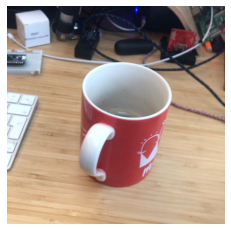

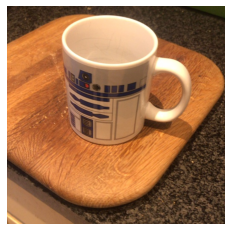

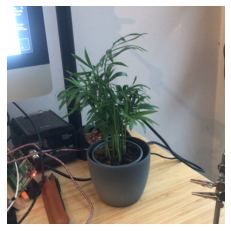

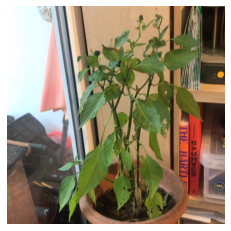

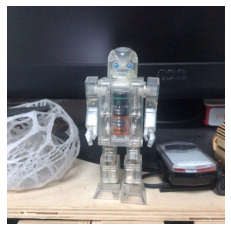

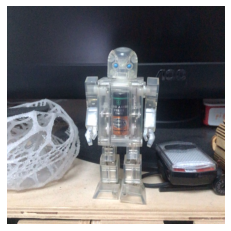

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_mugs = [os.path.join(mugs_dir, fname) 
                for fname in mugs_files[0:pic_index]]
next_plant = [os.path.join(plant_dir, fname) 
                for fname in plant_files[0:pic_index]]
next_unknown = [os.path.join(unknown_dir, fname) 
                for fname in unknown_files[0:pic_index]]

for i, img_path in enumerate(next_mugs+next_plant+next_unknown):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

### Use transfer learning to create new model

In [21]:
import keras.preprocessing
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# Note: ImageDataGenerator in Keras implements "in-place" augementation - ie it replaces
# the batch of images past in with a transformed set. 
# This means that when the network is trained, each Epoch sees new variations of our images
# https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/ 

TRAINING_DIR = "/content/training/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/content/validating/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

label_map = (train_generator.class_indices)
print("Classes found in data are: ", label_map)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

Found 110 images belonging to 3 classes.
Classes found in data are:  {'mugs': 0, 'plant': 1, 'unknown': 2}
Found 30 images belonging to 3 classes.


Next up we use a pretrained model as a starting point to build our new model. 

In [22]:
# defining a variable to hold image since since it is called in few places below
IMAGE_SIZE = [150, 150]

# load model without classifier layers

pretrained_model = VGG16(weights='imagenet', 
                         include_top=False ,
                         input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = MobileNetV2(input_shape=[*IMAGE_SIZE, 3], 
#                               include_top=False)
#pretrained_model = ResNet50(weights='imagenet', 
#                            include_top=False, 
#                            input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = MobileNet(weights='imagenet', 
#                             include_top=False, 
#                             input_shape=[*IMAGE_SIZE, 3])

pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 3)                 24579     
                                                                 
Total params: 14,739,267
Trainable params: 24,579
Non-trainable params: 14,714,688
_________________________________________________________________


Finaly we can run our training:

In [24]:
# Run training and save to history so that we can plot metrics
history = model.fit(train_generator, 
                    epochs=20, 
                    validation_data = validation_generator, 
                    verbose = 1)

# we can save the model so that we can reload at a later date
# It appears in the content folder - download it before your session ends
# https://www.tensorflow.org/guide/keras/save_and_serialize
model.save("mugsplant.h5")

Epoch 1/20
1/1 [==============================] - 9s 9s/step - loss: 1.1190 - accuracy: 0.4000 - val_loss: 0.9270 - val_accuracy: 0.5667
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 0.9966 - accuracy: 0.6000 - val_loss: 0.6339 - val_accuracy: 0.7333
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 0.7337 - accuracy: 0.7091 - val_loss: 0.4461 - val_accuracy: 0.9667
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 0.6222 - accuracy: 0.8182 - val_loss: 0.3472 - val_accuracy: 0.9667
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 0.5447 - accuracy: 0.8636 - val_loss: 0.2586 - val_accuracy: 0.9667
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 0.4668 - accuracy: 0.8818 - val_loss: 0.1904 - val_accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 2s 2s/step - loss: 0.3601 - accuracy: 0.9000 - val_loss: 0.1546 - val_accuracy: 1.0000
Epoch 8/20
1/1 [=========================

Once training is complete we can plot results - this should be starting to look familiar. 

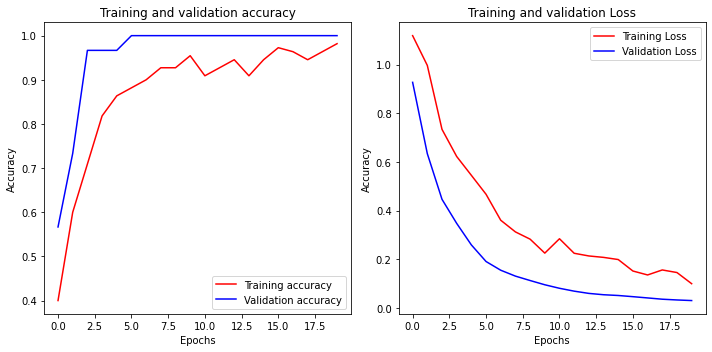

In [25]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc=0)

plt.subplot(1, 2, 2)

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc=0)

plt.tight_layout()


# Testing your model
To see how well this model has learnt you can upload an image and classify it. Some sample images have been included in the github repo in a folder called testing. You can drag and drop those into the Contents folder on left panel. 

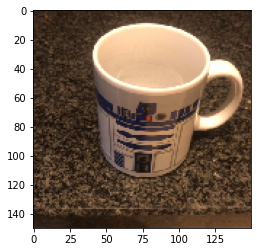

1/1 [==============================] - 0s 22ms/step
I think the image above is "mugs" and I am 100.00% confident.
[1. 0. 0.]


In [35]:
import numpy as np
from google.colab import files
from tensorflow import keras
from tensorflow.keras.preprocessing import image

# load an image from file
IMAGE_PATH = '/content/validating/mugs/mugs.1pnkg71r.ingestion-6cd7bdcf6c-mfj7c.jpg'
img = load_img(IMAGE_PATH, target_size=(150, 150))

plt.imshow(img)
plt.show()

# convert to an array that we can use as input to our model
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

# run prediction
p = model.predict(images)
  
# create a look up of the class labels generated from the 
# "flow_from_directory" method used in the generator and print result
predicted_class_indices = np.argmax(model.predict(x), axis=-1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

print('I think the image above is "%s" and I am %.2f%% confident.' % (predictions[0], p[0][predicted_class_indices]*100))

print(p[0])
